In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
%%time
cols = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1_zip3', 'r2_zip3', 'r3_zip3',
       'r4_zip3', 'r5_zip3', 'r6_zip3', 'r7_zip3', 'r8_zip3', 'r9_zip3',
       'r1_taxclass', 'r2_taxclass', 'r3_taxclass', 'r4_taxclass',
       'r5_taxclass', 'r6_taxclass', 'r7_taxclass', 'r8_taxclass',
       'r9_taxclass', 'r1_boro', 'r2_boro', 'r3_boro', 'r4_boro', 'r5_boro',
       'r6_boro', 'r7_boro', 'r8_boro', 'r9_boro']

# data_orig contains non-score columns
data_orig = pd.read_pickle('property_preprocessed.pickle')

# data contains only score columns
data = data_orig[cols].copy()

# Therefore, after extracting from data_orig the score columns
# I am dropping all the score columns from data_origh
data_orig.drop(columns=cols, inplace=True)
data.head(2)

CPU times: user 1.67 s, sys: 1.48 s, total: 3.15 s
Wall time: 3.15 s


,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,40.917782,3994.412456,723.985188,8.079350,788.709805,142.953243,18.413002,1797.485605,325.793334,0.096029,...,4.715588,0.113902,7.712077,6.469193,0.241395,16.606462,13.685555,0.198288,14.042014,14.957255
1,57678.882190,36173.697854,6556.463990,4258.951518,2671.030012,484.122805,25955.496986,16278.164034,2950.408795,135.364878,...,42.704717,160.560217,69.841147,58.585497,127.249178,56.239136,46.347248,279.513149,127.165526,135.454020


In [3]:
%%time
#Z scale the variables before PCA.
data = (data - data.mean()) / data.std()
print("standardized")

standardized
CPU times: user 660 ms, sys: 459 ms, total: 1.12 s
Wall time: 773 ms


(0.0, 1.0)

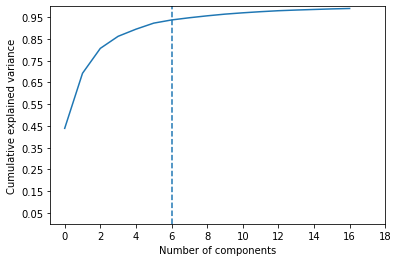

In [4]:
#First, compute most of the PC components and look at the scree plot.
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1)

In [5]:
#Now decide to just keep the top 6 PCs. Recompute them.
pca = PCA(n_components = 6)
princ_comps = pca.fit_transform(data)
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

#Z scale the PC’s
pca_mean = data_pca.mean()
pca_sd = data_pca.std()
data_pca = (data_pca - pca_mean) / pca_sd
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,-2.158997e-16,7.390330e-16,-1.942744e-16,7.300055e-16,3.958958e-15,-8.391092e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.585169e-01,-2.280285e+02,-1.990058e+02,-2.023902e+02,-2.438876e+02,-2.002482e+02
25%,-1.088008e-01,-1.544611e-01,-1.356178e-01,-3.269417e-02,-1.159057e-01,-1.101847e-01
50%,-2.375699e-02,-5.919442e-02,6.964989e-04,1.366912e-02,-1.313743e-02,-2.535285e-02
75%,3.290240e-02,3.225958e-02,3.206016e-01,7.018403e-02,4.879502e-02,1.382269e-01
max,6.907817e+02,3.239819e+02,5.967327e+02,2.507935e+02,4.068856e+02,4.017189e+02


### Model 1: z score outliers
Pretty simple once the data’s prepared. Here we chose the power in the distance formula to be 2, which is the Euclidean distance.

In [6]:
p=2
one_over_p = 1/p
score1 = (((data_pca).abs()**p).sum(axis=1))**one_over_p

### Model 2: autoencoder error
1. Compress the data records from 6 to 3 dimensions. Expand them back to 6 dimensions.
2. Train the autoencoder. We don’t need the autoencoder to be a really good model so we don’t need to train a lot. Even a weak model will still have large error on the strange records and the errors on the normal records will still be much smaller.
3. Score 2 is the difference between the input and output vectors of the autoencoder (autoencoder error). We choose the Euclidean distance again (power 2).

In [7]:
from keras.models import Model
from keras.layers import Input, Dense

# placeholder for input
data_in = Input(shape=(6,))
# dimension of the encoded data. Choose 3
encoded_dim = 3
# encoded representation of the data
encoded = Dense(encoded_dim, activation='tanh')(data_in)
# reconstruction of the input
decoded = Dense(6,activation='tanh')(encoded)
# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(data_pca,data_pca, epochs=3, shuffle=True, validation_data=(data_pca,data_pca))

pca_out = autoencoder.predict(data_pca)
error = pca_out-data_pca
p=2
oop=1/p
score2 = ((error.abs()**p).sum(axis=1))**oop

Epoch 1/3
32714/32714 [==============================] - 53s 2ms/step - loss: 0.8094 - val_loss: 0.8953
Epoch 2/3
32714/32714 [==============================] - 54s 2ms/step - loss: 0.9322 - val_loss: 0.8947
Epoch 3/3
32714/32714 [==============================] - 52s 2ms/step - loss: 0.8687 - val_loss: 0.8948


### Make the final score as the average ranking

In [8]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores['final'] = (scores['score1 rank'] + scores['score2 rank'])/2
top_records = scores.sort_values(['final'], ascending = False).head(100).index

(0.1, 2088582.7348885664)

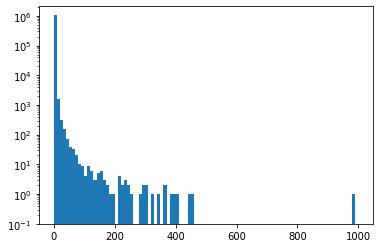

In [9]:
plt.hist(score1, bins = 100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

(0.1, 2090092.3664951806)

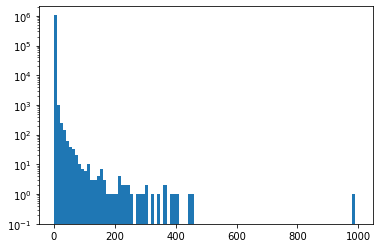

In [10]:
plt.hist(score2, bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='final', ylabel='Density'>

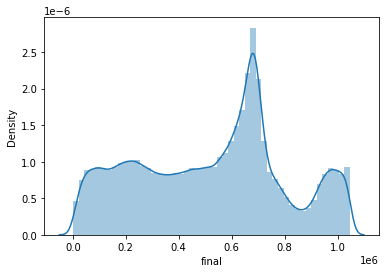

In [11]:
sns.distplot(scores['final'])

In [18]:
submission = (
    data_orig.drop(columns = ['ltsize','bldsize','bldvol','zip3'])
    .join(scores[['score1','score2','final']], how="inner")
    .sort_values(by="final", ascending=False)
    .head(100)
)

In [21]:
submission.to_csv("top100.csv", index=False)

In [19]:
submission.columns

Index(['RECORD', 'BBLE', 'B', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'score1', 'score2', 'final'],
      dtype='object')

In [20]:
submission.shape

(100, 35)

In [16]:
data.head(2)

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,-0.324189,3.365634,0.962071,-0.034088,2.023461,0.745320,-0.041301,1.874086,0.937911,-0.417857,...,0.660210,-0.374523,3.352458,2.151291,-0.120245,0.910164,0.790755,-0.110174,0.594662,0.887478
1,107.903135,34.685411,12.654552,60.713604,6.996480,2.658471,127.179921,17.407961,8.963675,62.109671,...,7.410371,67.440601,34.383853,22.651090,20.011593,3.221530,2.826725,38.274168,5.752631,8.549314
